In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout, BatchNormalization
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Загрузка и предобработка данных
df = pd.read_csv("updated_pollution_dataset.csv")
df = df.drop(columns=['Air Quality'])


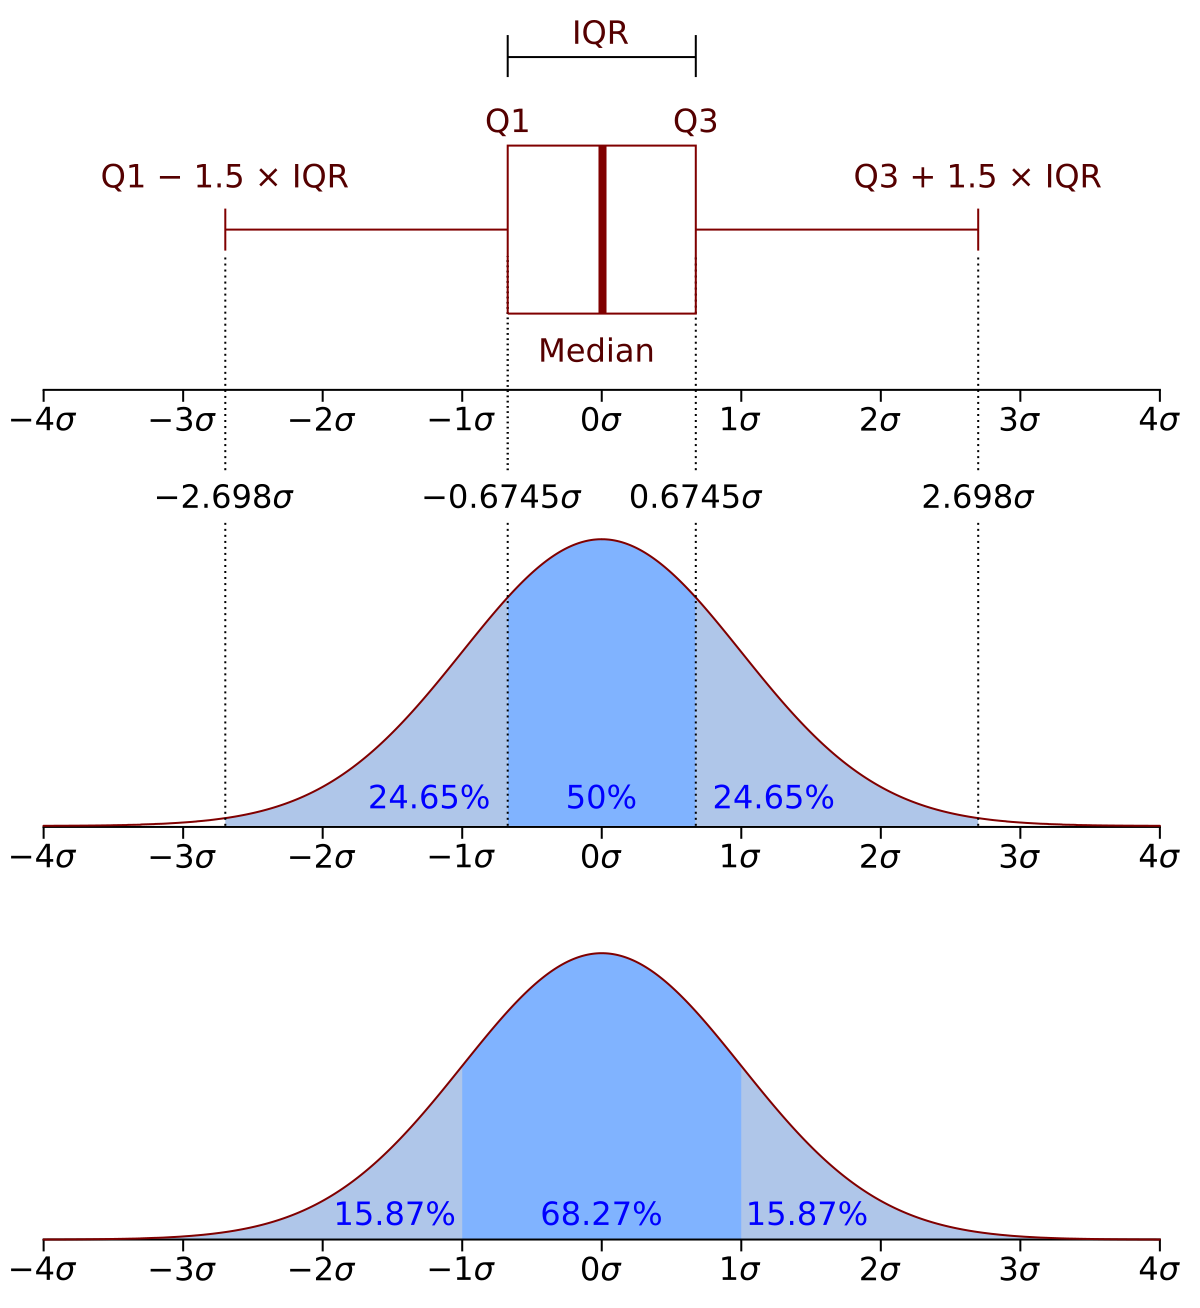

In [ ]:
# Удаление выбросов через IQR
Q1 = df['PM10'].quantile(0.25)
Q3 = df['PM10'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['PM10'] >= (Q1 - 1.5 * IQR)) & (df['PM10'] <= (Q3 + 1.5 * IQR))]

# Разделение на признаки и целевую переменную
X = df.drop(columns=['PM10'])
y = df[['PM10']]

# Масштабирование данных
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(np.log1p(y))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [ ]:
# Нейросеть с EarlyStopping
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# EarlyStopping для остановки при переобучении
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Используем часть train для валидации
    epochs=100,  # Ставим больше эпох, но EarlyStopping остановит раньше
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0837 - mae: 0.2166 - val_loss: 0.0560 - val_mae: 0.1692
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0840 - mae: 0.2176 - val_loss: 0.0680 - val_mae: 0.1981
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0916 - mae: 0.2269 - val_loss: 0.0609 - val_mae: 0.1722
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0903 - mae: 0.2253 - val_loss: 0.0538 - val_mae: 0.1673
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0899 - mae: 0.2253 - val_loss: 0.0520 - val_mae: 0.1651
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0926 - mae: 0.2239 - val_loss: 0.0675 - val_mae: 0.1808
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0835 - mae: 0.2146 - val_loss: 0.0551 - val_mae: 0.1694
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0782 - mae: 0.2106 - val_loss: 0.0626 - val_mae: 0.1812
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Ансамбль (среднее предсказаний)
nn_pred = model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
ensemble_pred = (nn_pred.flatten() + xgb_pred) / 2


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Оценка качества
y_test_real = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1, 1))).flatten()
ensemble_real = np.expm1(scaler_y.inverse_transform(ensemble_pred.reshape(-1, 1))).flatten()

print(f"MAE: {mean_absolute_error(y_test_real, ensemble_real):.2f}")
print(f"R²: {r2_score(y_test_real, ensemble_real):.4f}")


MAE: 3.38
R²: 0.9197


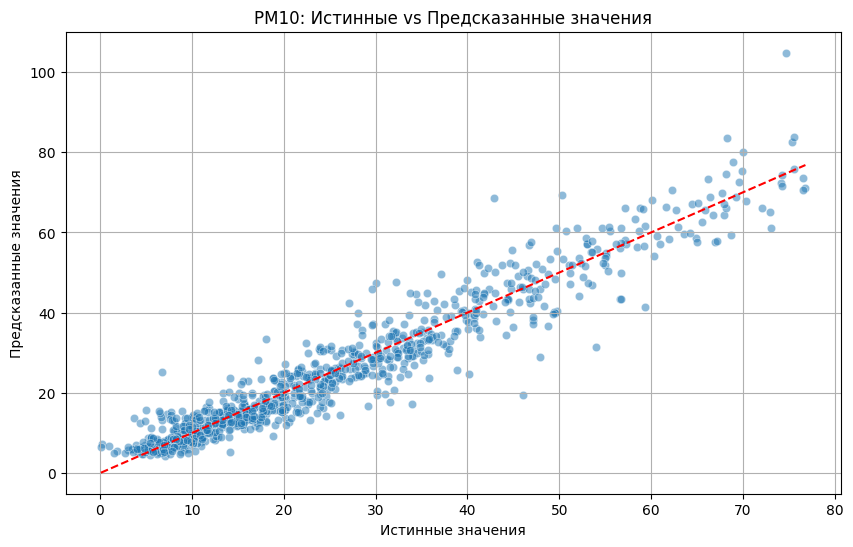

In [ ]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_real, y=ensemble_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.title("PM10: Истинные vs Предсказанные значения")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.grid()
plt.show()